In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
df = pd.read_excel("premiums_young.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [3]:
df.shape

(20096, 13)

In [4]:
df.columns#so many spaces i can see 

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [5]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Handle Missing Values

In [6]:
df.isna().sum()#to check NA value

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [10]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

In [11]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [12]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

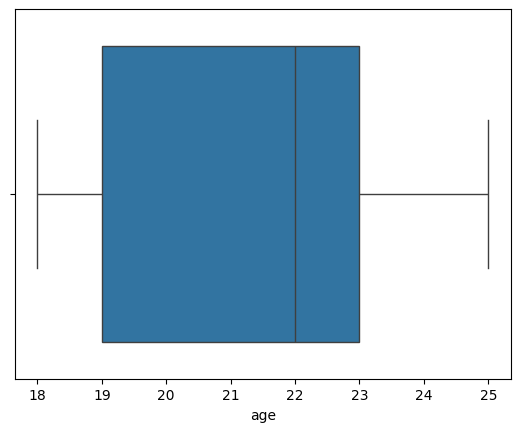

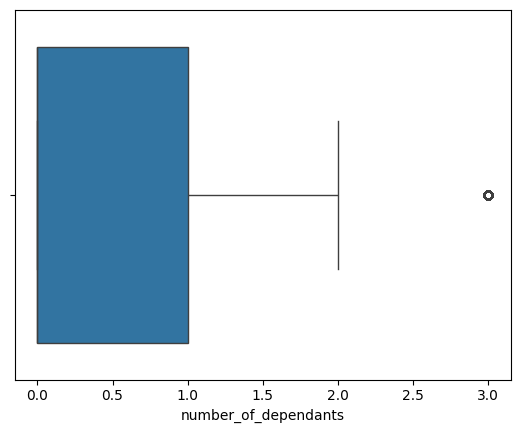

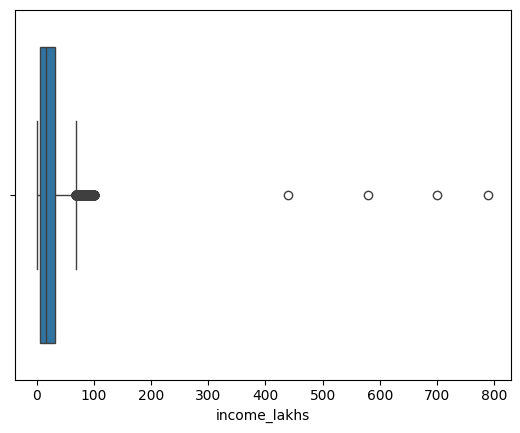

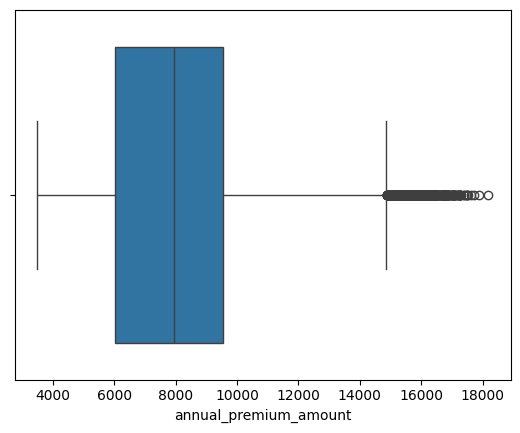

In [13]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [14]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [15]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [16]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [17]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [18]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [19]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


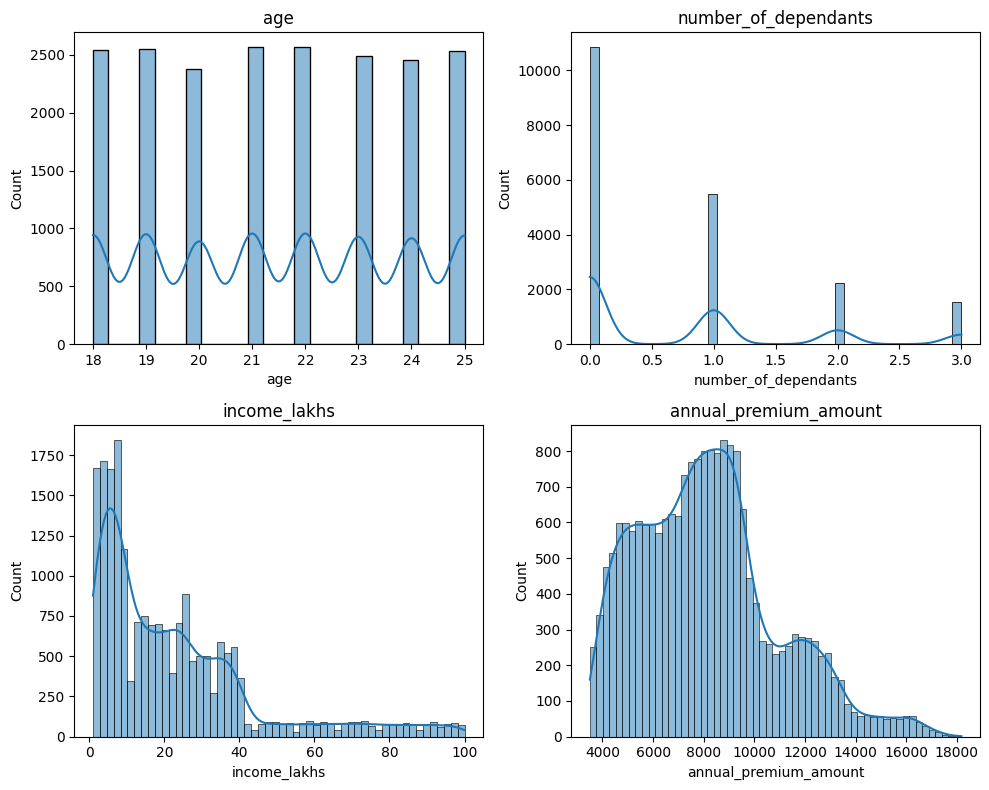

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Get the first 4 columns, which is the size of your 2x2 grid
columns_to_plot = numeric_columns[:4]

# Loop through only the selected columns
for i, column in enumerate(columns_to_plot):
    ax = axs[i//2, i%2]
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

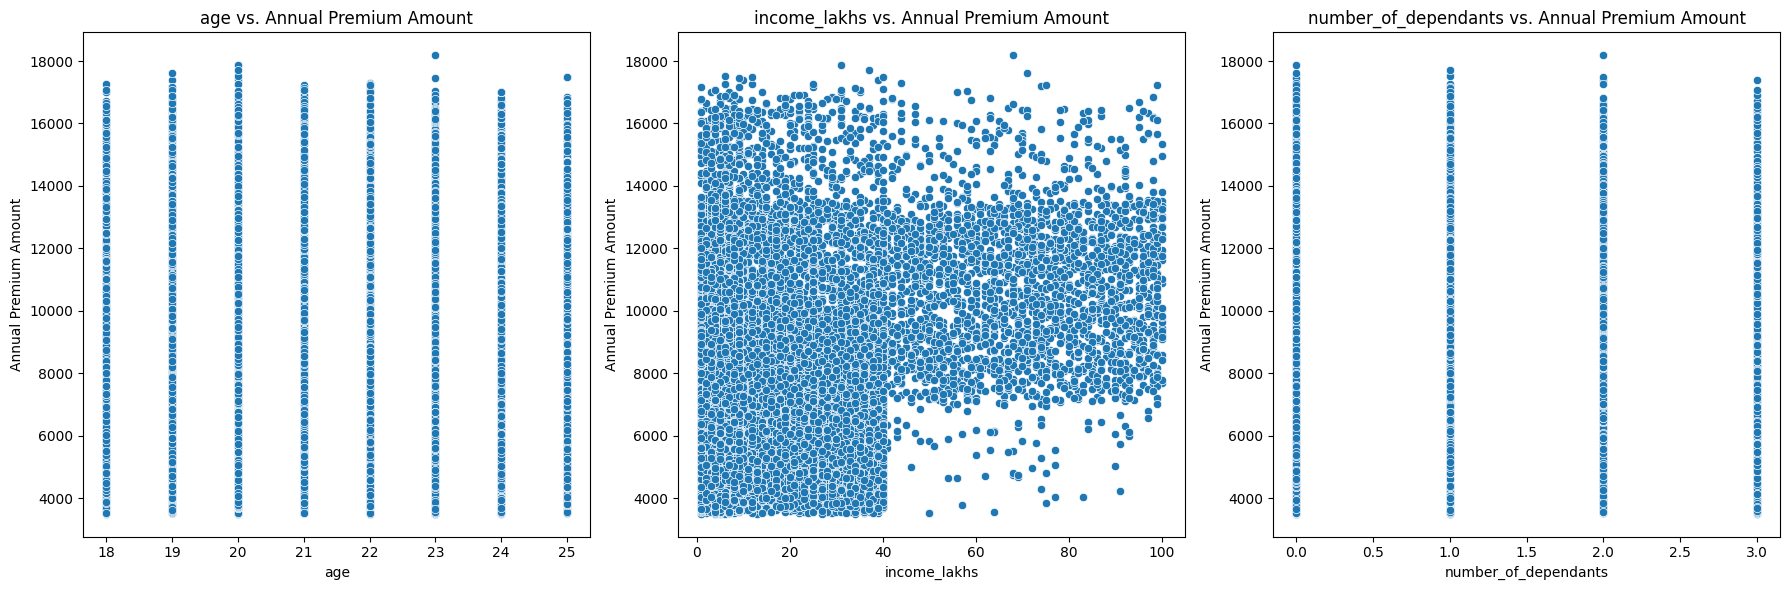

In [21]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [22]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [23]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking=0': 'No Smoking'
},inplace =True)
df2['smoking_status'].unique()

C:\Users\krish\AppData\Local\Temp\ipykernel_27344\1244617019.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional', 'Not Smoking'], dtype=object)

In [24]:
pct_count= df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [25]:
pct_count.values

array([0.55038335, 0.44961665])

<Axes: xlabel='gender'>

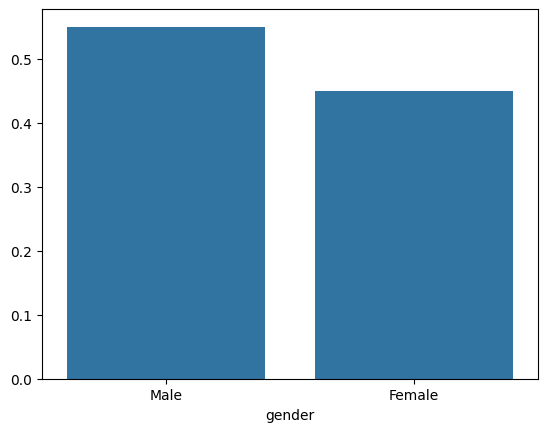

In [26]:
sns.barplot(x=pct_count.index,y=pct_count.values)

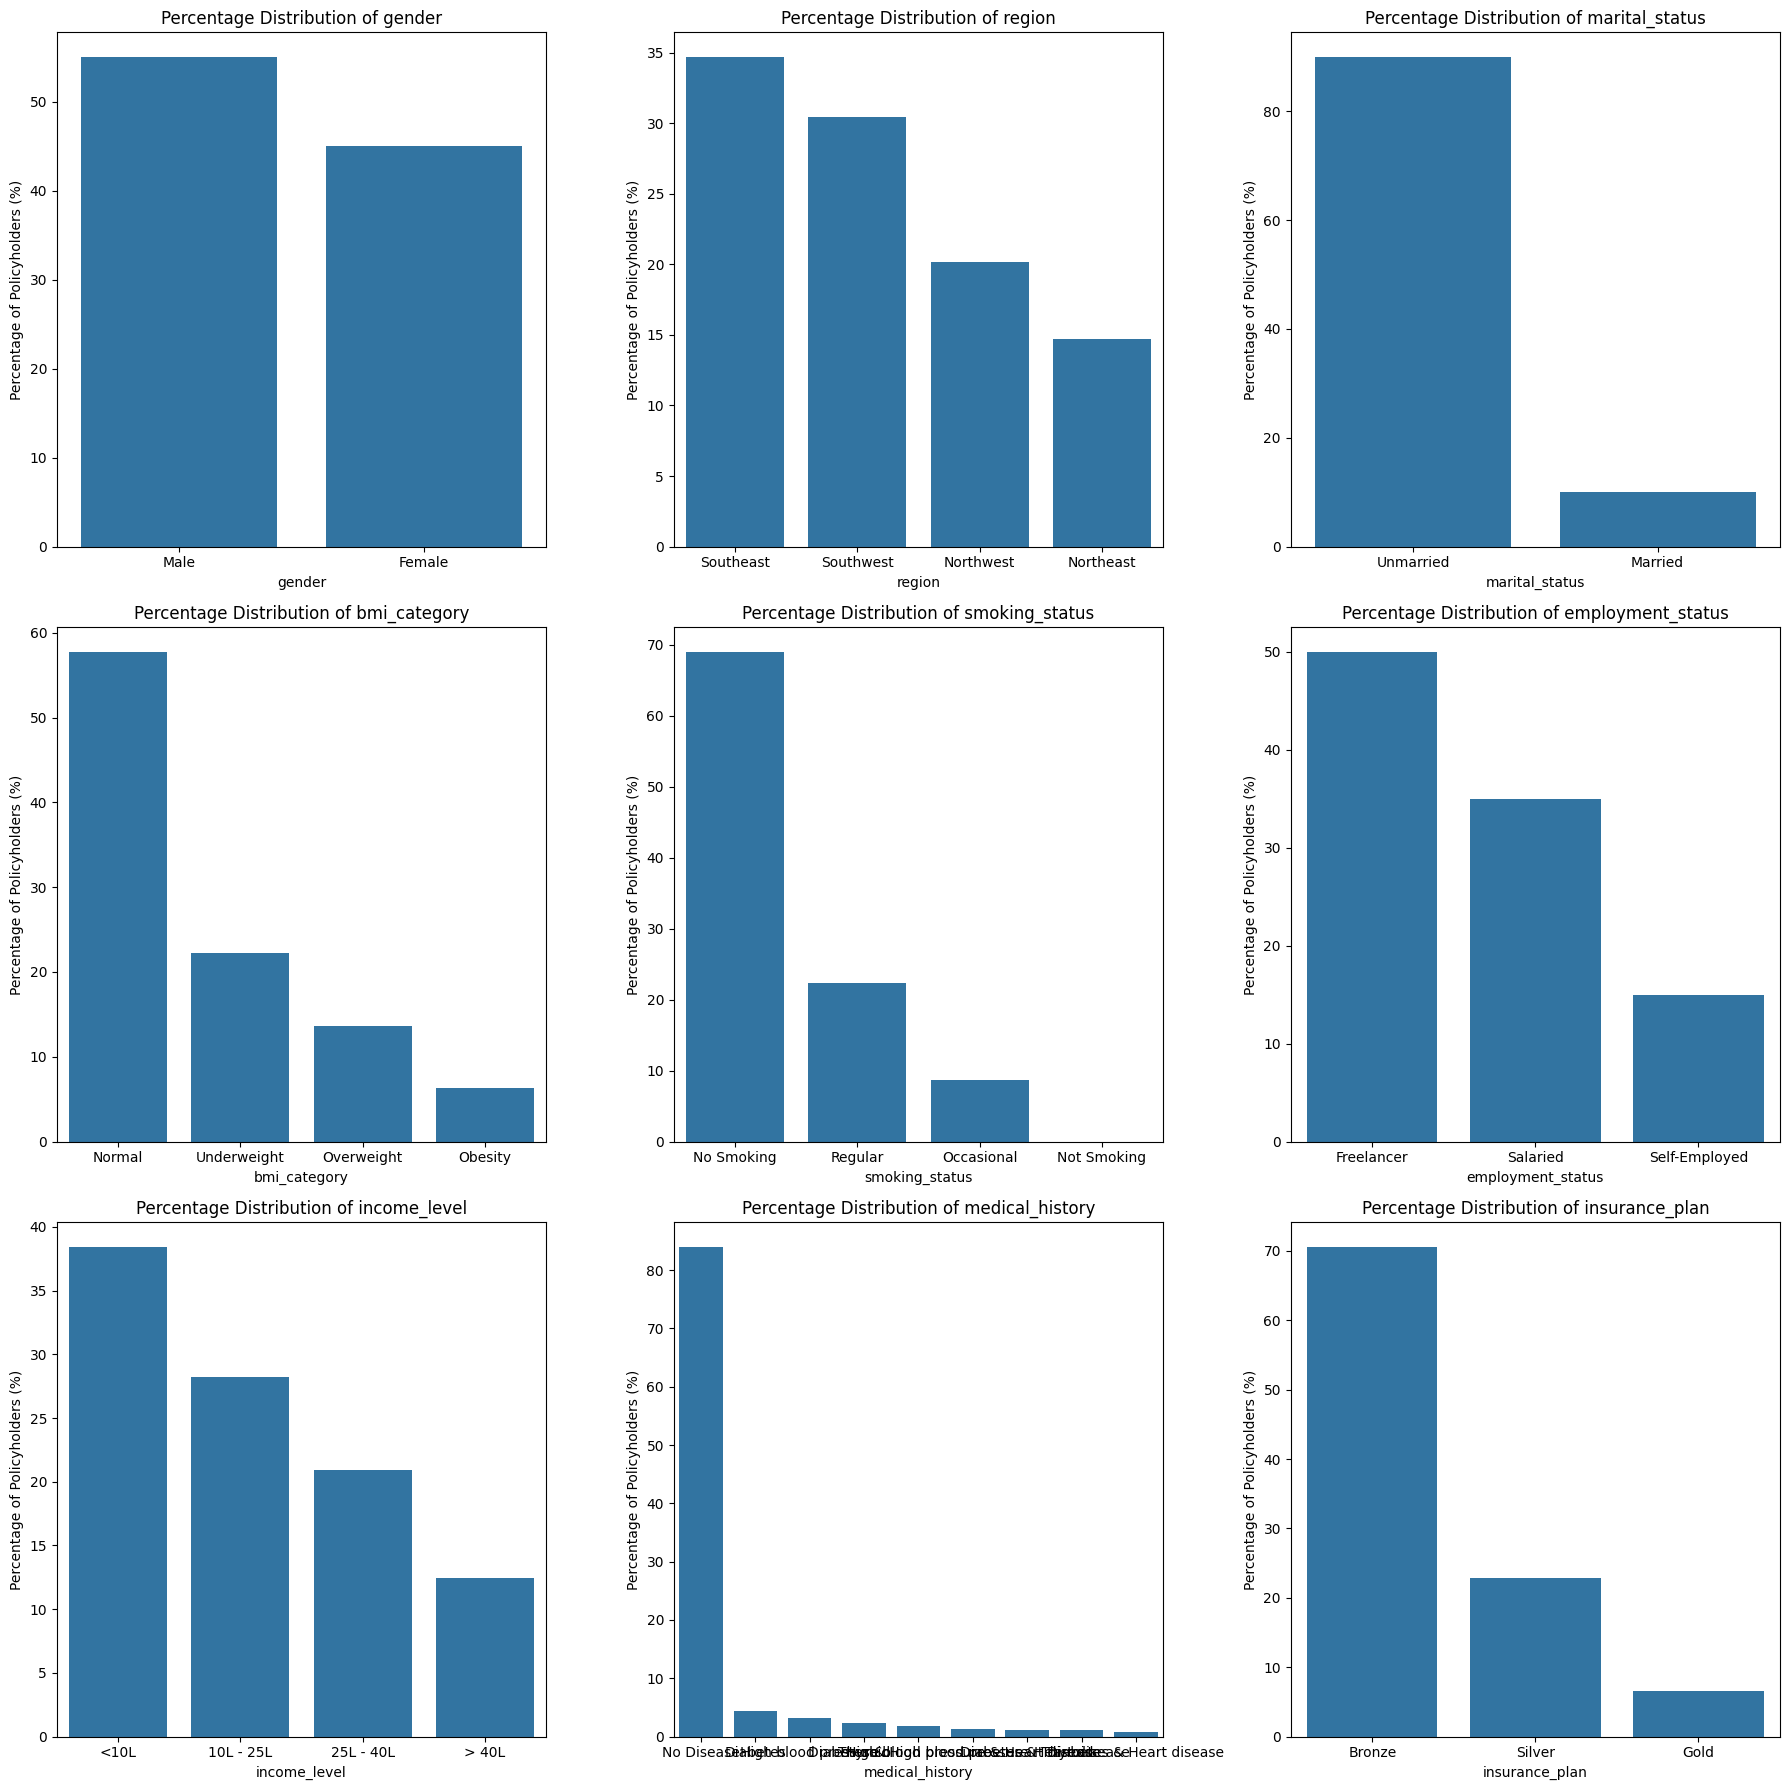

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


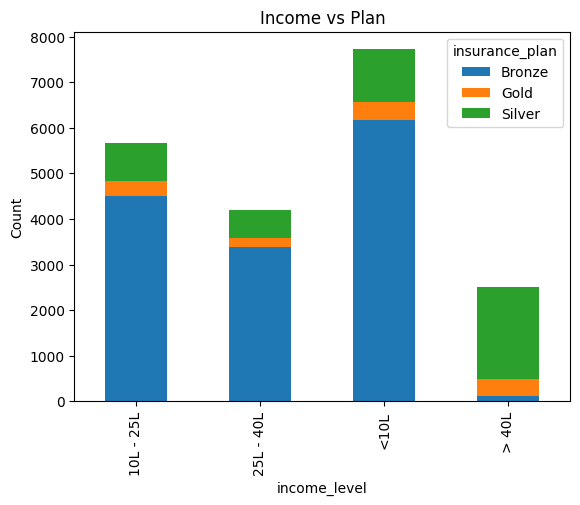

In [28]:
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar',stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

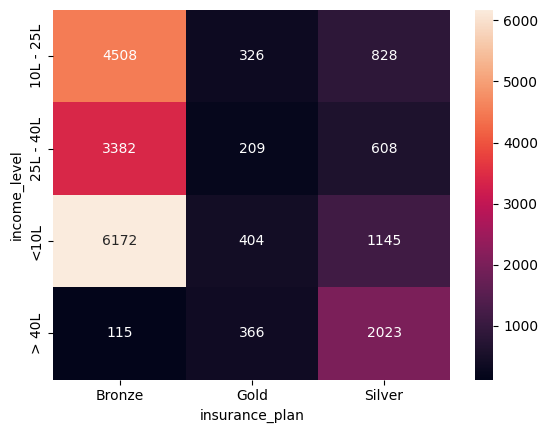

In [29]:
sns.heatmap(crosstab,annot=True,fmt='d')

In [30]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [31]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [32]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}
df2[['disease1','disease2']] = df2['medical_history'].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None


In [33]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/ (max_score - min_score)
df2.head(2)

C:\Users\krish\AppData\Local\Temp\ipykernel_27344\1997201259.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace=True)
C:\Users\krish\AppData\Local\Temp\ipykernel_27344\1997201259.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


In [34]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [35]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1,'Silver':2,'Gold':3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [36]:
df2['income_level'] = df2['income_level'].map({'<10L':1,'10L - 25L':2,'25L - 40L':3,'>40L':4})
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,NaN,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1.0,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,NaN,97,No Disease,2,11857,no disease,none,0,0.000000


In [37]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,NaN,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,1,0,1,0,0,0,1,0,1
1,22,0,1.0,3,No Disease,2,11050,no disease,none,0,...,0,1,0,0,1,0,0,0,0,0
2,21,0,NaN,97,No Disease,2,11857,no disease,none,0,...,0,1,0,0,0,0,0,1,1,0


In [38]:
df4 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,NaN,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,0,1,0,1
1,22,0,1.0,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0,0
2,21,0,NaN,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,0,1,1,0


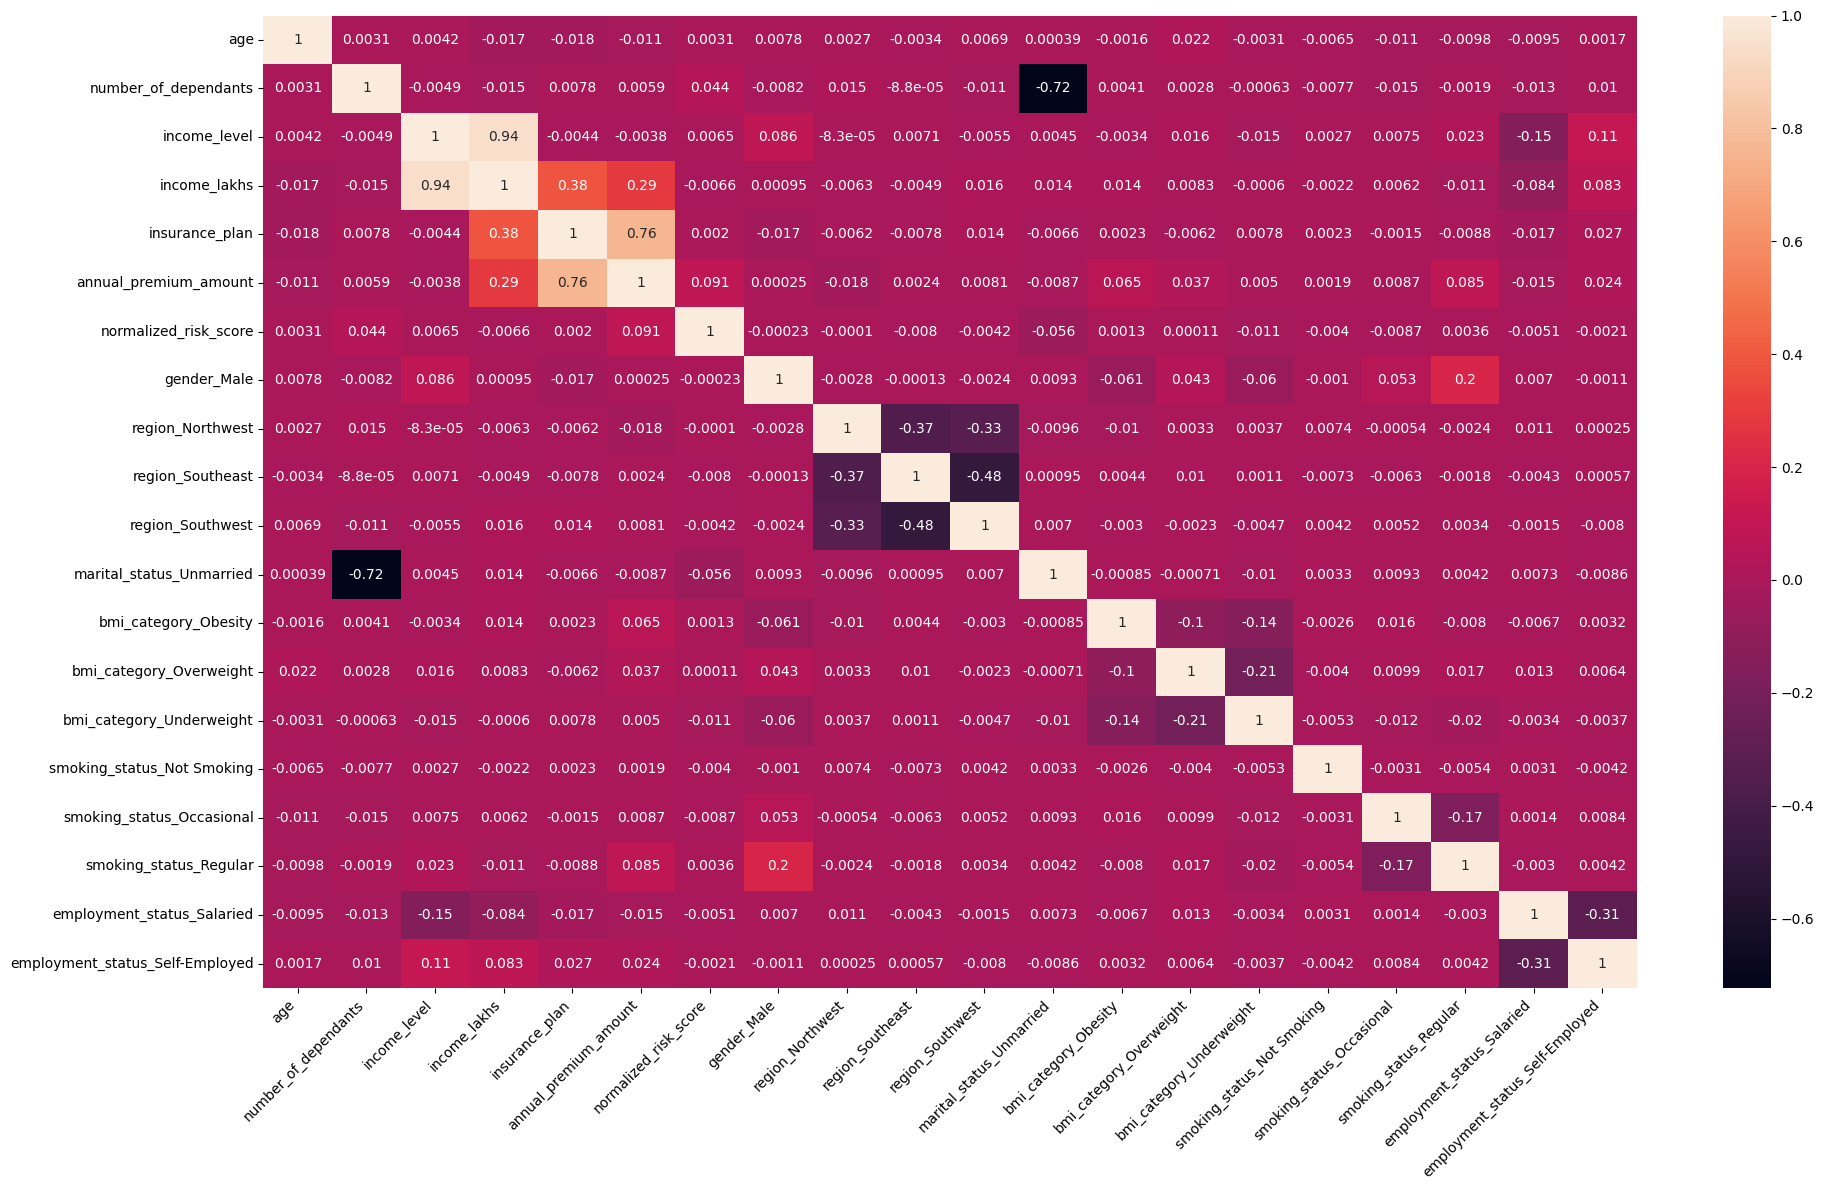

In [39]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,NaN,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,0,1,0,1
1,22,0,1.0,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0,0


In [41]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,17582.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.399841,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.000100,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.399335,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.009978,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.500000,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.500000,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [43]:
# Check for inf and NaN values
print("Checking for problematic values:")
print("NaN count:\n", X.isnull().sum())
print("\nInf count:\n", np.isinf(X).sum())

# Replace inf with NaN, then drop or fill
X_clean = X.replace([np.inf, -np.inf], np.nan)

# Option A: Drop rows with NaN
X_clean = X_clean.dropna()

# OR Option B: Fill NaN with median
# X_clean = X_clean.fillna(X_clean.median())

# Now calculate VIF
calculate_vif(X_clean)

Checking for problematic values:
NaN count:
 age                                   0
number_of_dependants                  0
income_level                       2504
income_lakhs                          0
insurance_plan                        0
normalized_risk_score                 0
gender_Male                           0
region_Northwest                      0
region_Southeast                      0
region_Southwest                      0
marital_status_Unmarried              0
bmi_category_Obesity                  0
bmi_category_Overweight               0
bmi_category_Underweight              0
smoking_status_Not Smoking            0
smoking_status_Occasional             0
smoking_status_Regular                0
employment_status_Salaried            0
employment_status_Self-Employed       0
dtype: int64

Inf count:
 age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan       

,Column,VIF
0,age,3.170000
1,number_of_dependants,1.916002
2,income_level,17.645048
3,income_lakhs,22.445061
4,insurance_plan,1.211347
5,normalized_risk_score,1.156316
6,gender_Male,2.367261
7,region_Northwest,2.158040
8,region_Southeast,2.982887
9,region_Southwest,2.697261


In [44]:
calculate_vif(X.drop('income_level',axis='columns'))

,Column,VIF
0,age,3.141609
1,number_of_dependants,1.858135
2,income_lakhs,2.291885
3,insurance_plan,1.587816
4,normalized_risk_score,1.154185
5,gender_Male,2.299852
6,region_Northwest,2.146986
7,region_Southeast,2.969015
8,region_Southwest,2.729992
9,marital_status_Unmarried,7.299965


In [45]:
X_reduced = X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0,0


# Model Training

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X_reduced,y,test_size=0.3,random_state=10)

print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


In [47]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)
train_score,test_score

(0.6020795306666503, 0.6044622058347546)

In [48]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ",mse_lr,"RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3007926.258872107 RMSE:  1734.3374120603255


In [49]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0,0


In [50]:
model_lr.intercept_

np.float64(6615.5865172451995)

In [51]:
model_lr.coef_

array([ 5.47578381e+01, -1.45527142e+02, -3.67837288e+01,  7.00072192e+03,
        1.11104304e+03,  9.55853081e+00, -1.14259009e+02, -3.64547868e+01,
       -6.67840830e+01, -5.87559716e+01,  7.92704539e+02,  4.35570935e+02,
        1.69484199e+02, -1.85451444e+03,  2.44660712e+02,  6.18949352e+02,
       -1.33377507e+01, -4.57990957e+00])

In [52]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Not Smoking',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

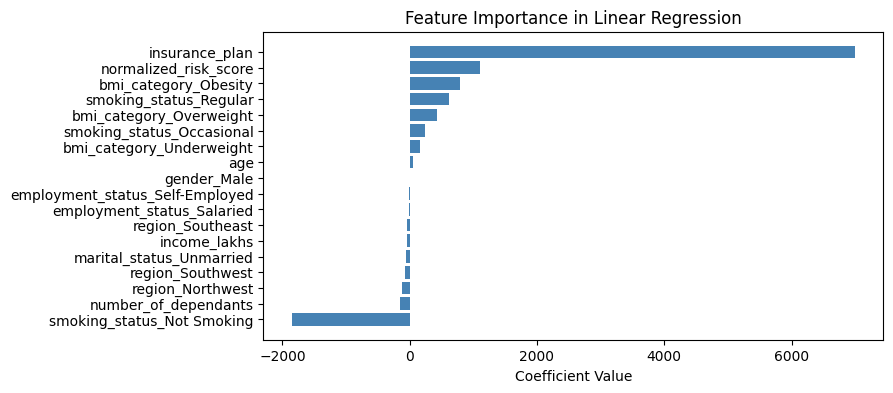

In [53]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by="Coefficients",ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [54]:
model_rg = Ridge(alpha=10)
model_lr.fit(X_train,y_train)
train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)
train_score,test_score

(0.6020795306666503, 0.6044622058347546)

In [55]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train)
train_score = model_xgb.score(X_train,y_train)
test_score = model_xgb.score(X_test,y_test)
train_score,test_score

(0.7176214456558228, 0.5678246021270752)

In [56]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ",mse_lr,"RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3286542.5 RMSE:  1812.8823734594587


In [57]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [58]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [78]:
best_model = model_lr

# Error Analysis

In [80]:
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6625.342725,387.342725,6.209406
14758,9462,7117.831685,-2344.168315,-24.774554
13205,5152,7051.901465,1899.901465,36.876969
14278,6988,7924.017714,936.017714,13.394644
19351,4917,6696.663858,1779.663858,36.194099


<Axes: xlabel='diff_pct', ylabel='Count'>

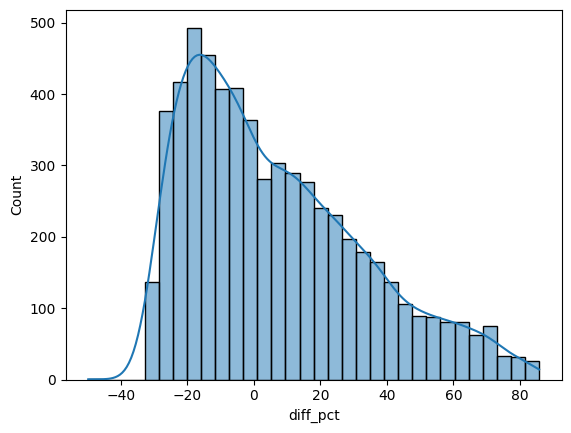

In [81]:
sns.histplot(results_df['diff_pct'],kde=True)

In [82]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4404, 4)

In [83]:
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

73.08330567540658

In [84]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct',ascending=False)

,actual,predicted,diff,diff_pct
10288,3623,6730.165387,3107.165387,85.762224
16580,3538,6566.817714,3028.817714,85.608189
3652,3536,6561.014590,3025.014590,85.549055
17084,3562,6608.142566,3046.142566,85.517759
18629,3616,6683.958935,3067.958935,84.843997
...,...,...,...,...
1597,4653,6988.519920,2335.519920,50.193852
12185,4440,6667.431239,2227.431239,50.167370
15966,4709,7070.355491,2361.355491,50.145583
4086,4592,6890.480378,2298.480378,50.054015


In [85]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [86]:
extreme_results_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
       10266,  5484,  8988,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4404)

In [87]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0,0


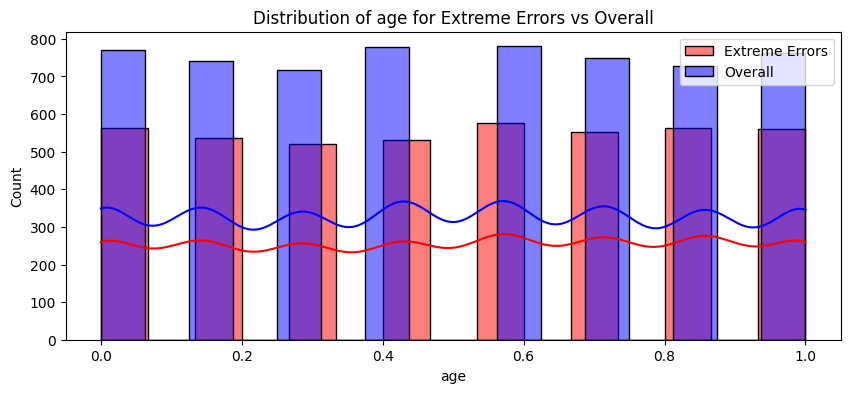

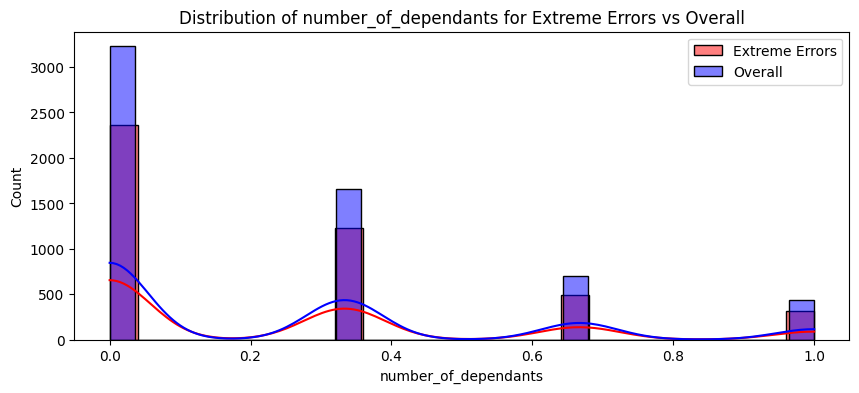

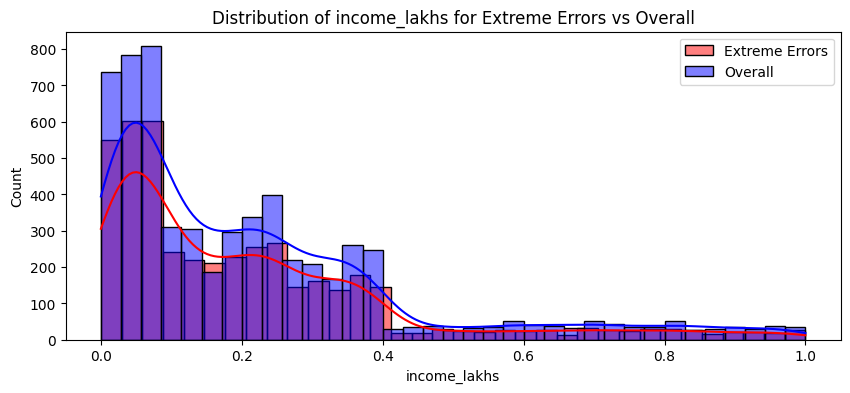

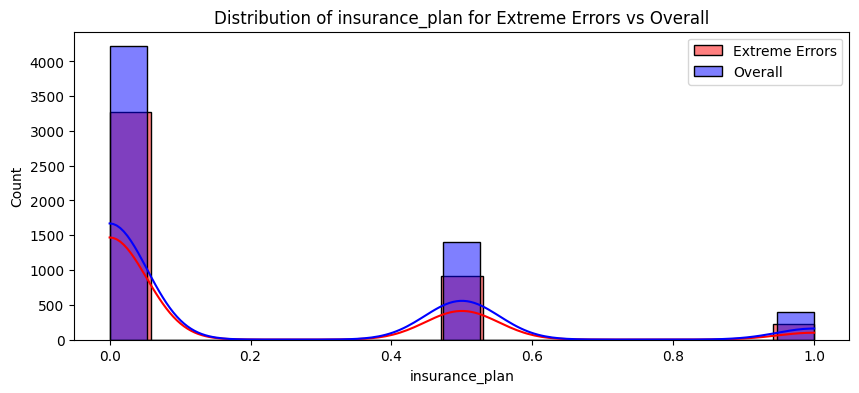

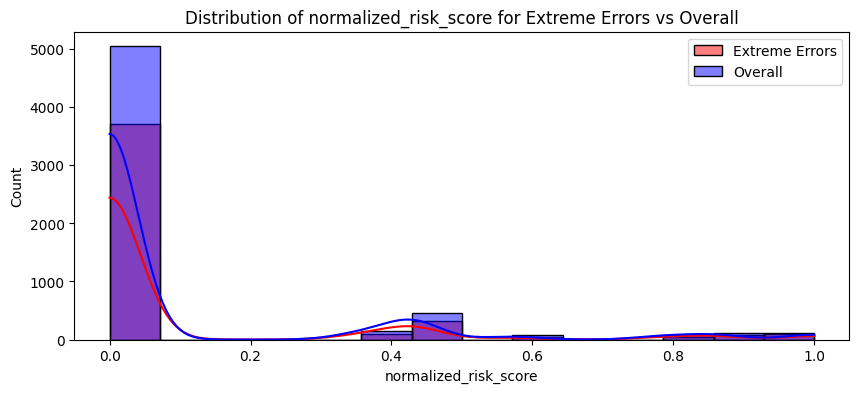

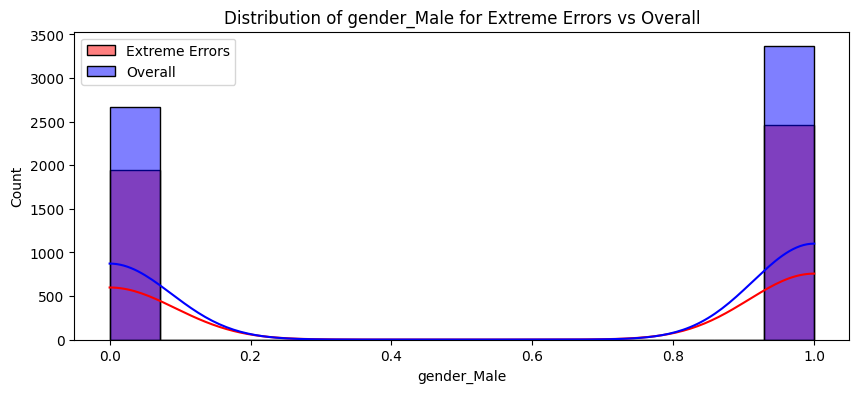

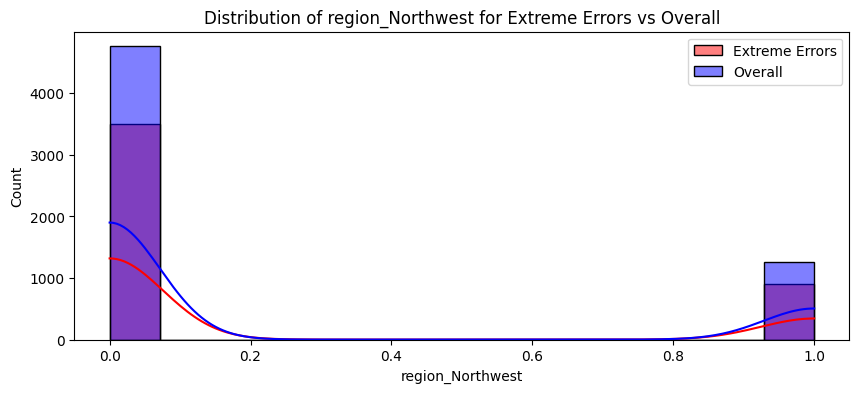

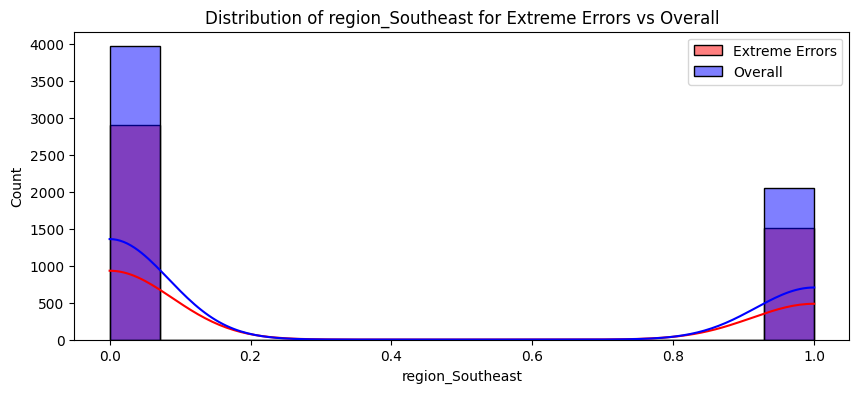

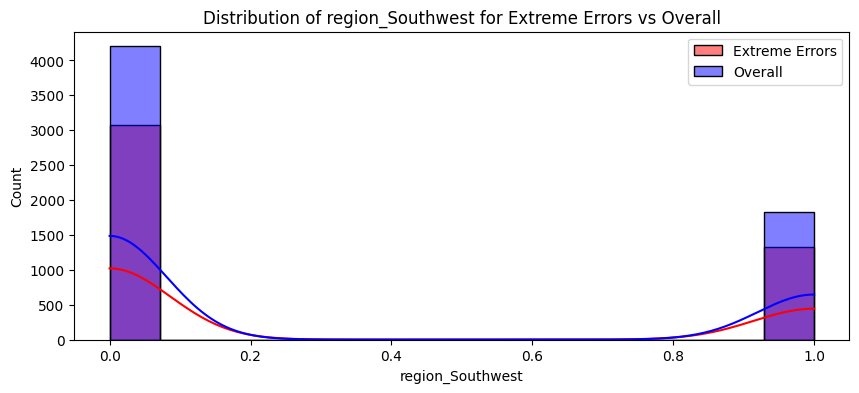

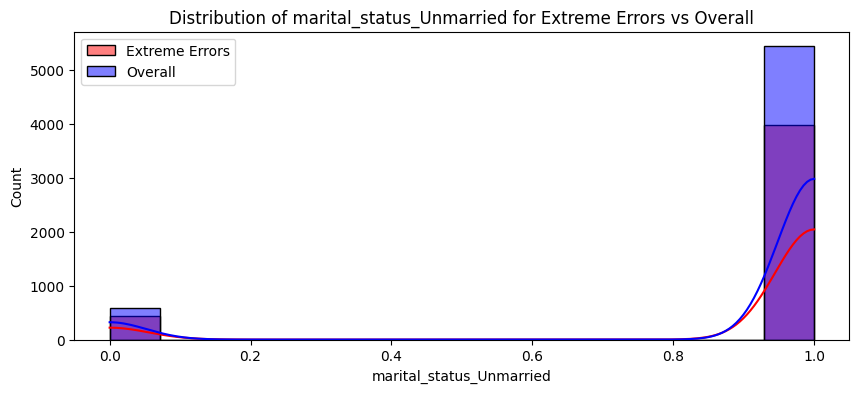

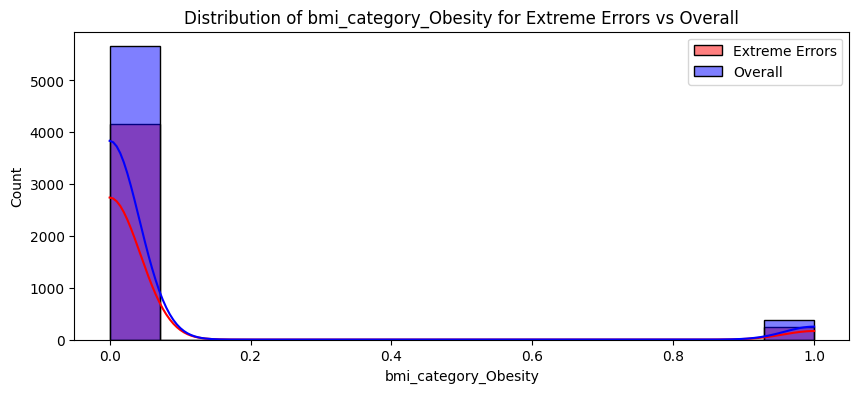

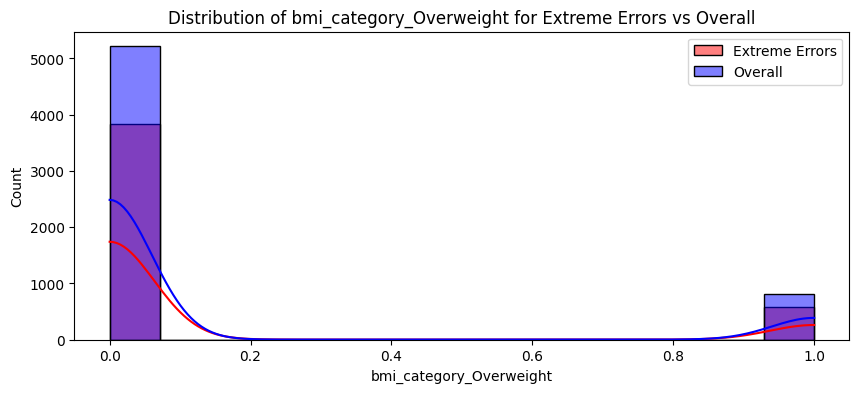

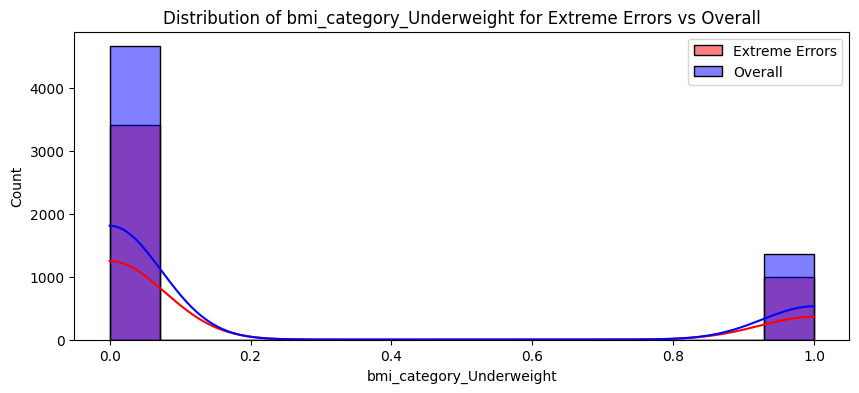

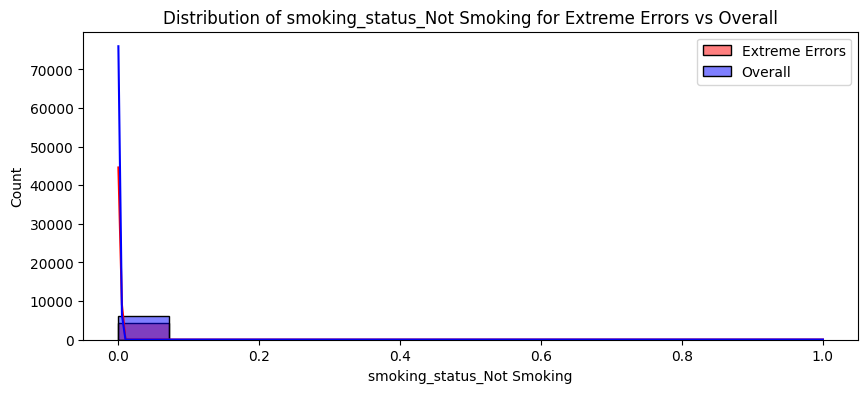

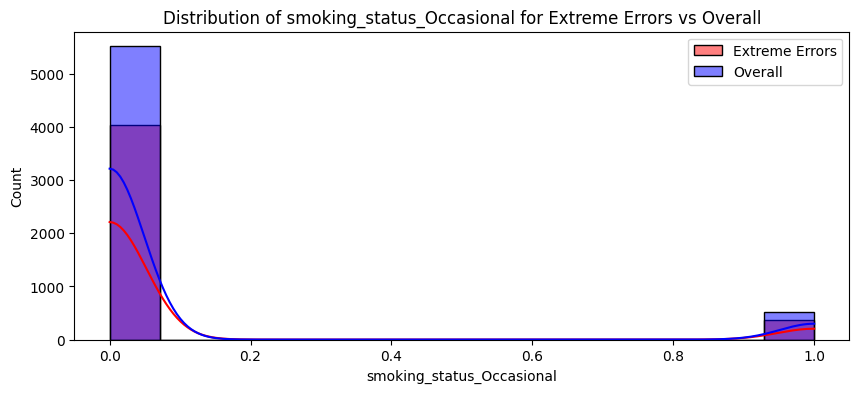

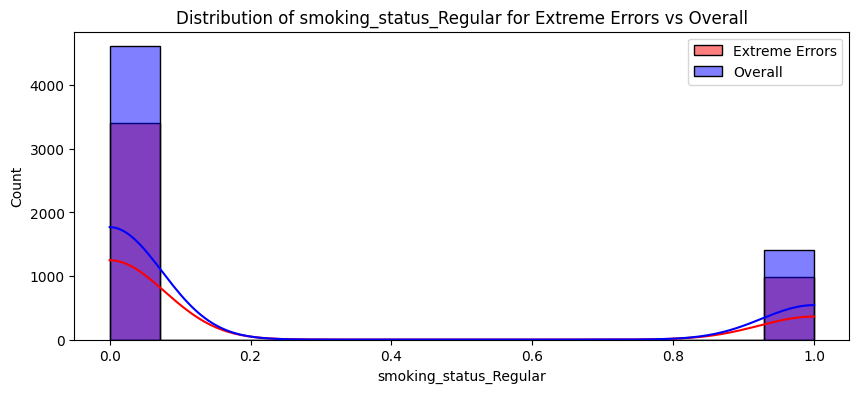

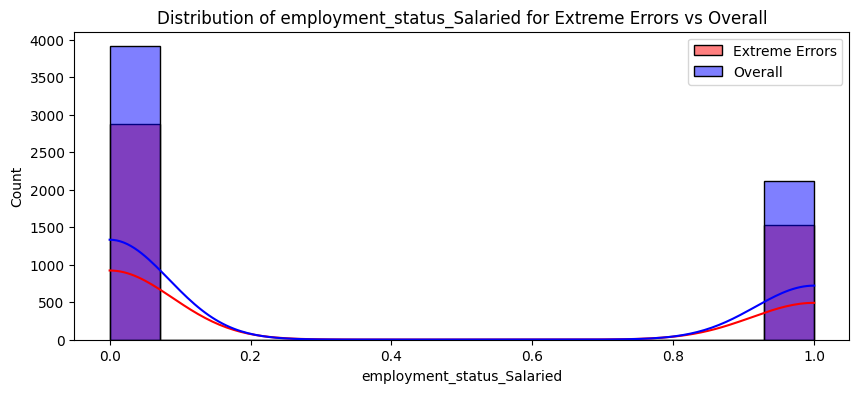

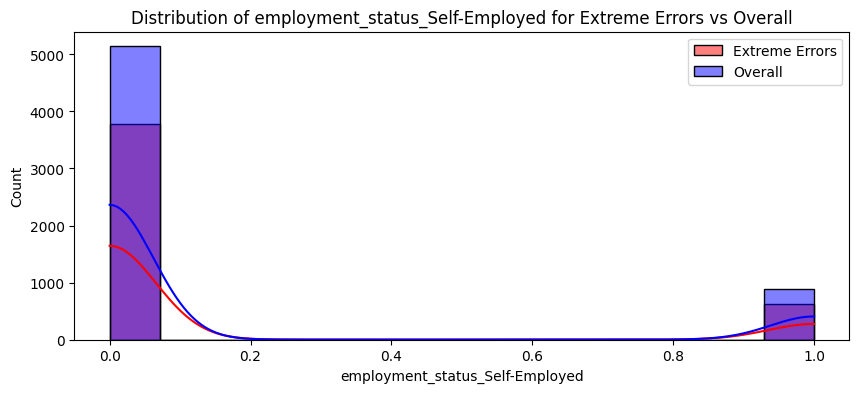

In [88]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

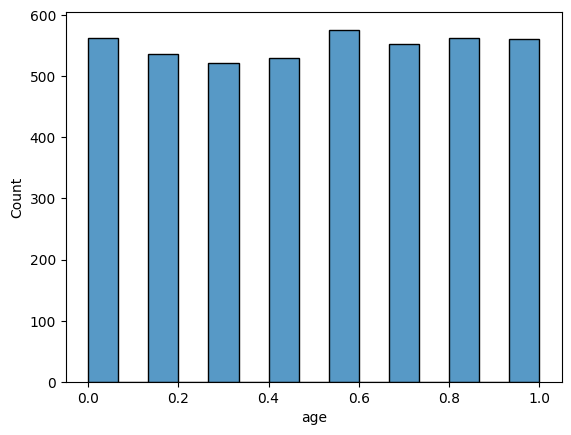

In [89]:
sns.histplot(extreme_errors_df.age)

In [90]:
extreme_errors_df['income_level']=-1

In [91]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

<Axes: xlabel='age', ylabel='Count'>

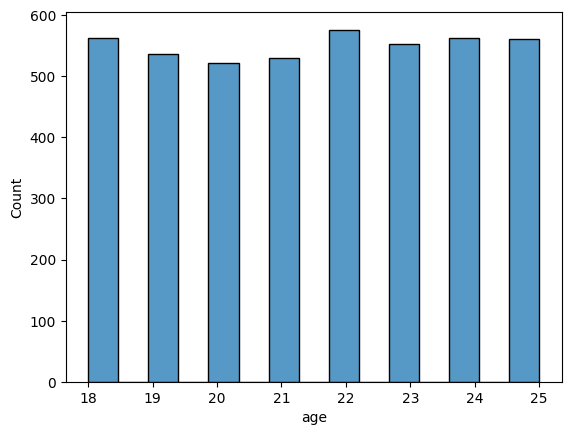

In [92]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed['age'])

In [93]:
df_reversed.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-1.0,7.0,1.0
1,23.0,1.0,-1.0,15.0,1.0
2,23.0,1.0,-1.0,23.0,1.0
3,22.0,0.0,-1.0,11.0,1.0
4,21.0,1.0,-1.0,6.0,1.0


In [94]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4404.000000,4404.000000,4404.0,4404.000000,4404.000000
mean,21.529292,0.719346,-1.0,21.506585,1.307902
std,2.302041,0.926202,0.0,20.970951,0.559534
min,18.000000,0.000000,-1.0,1.000000,1.000000
25%,20.000000,0.000000,-1.0,6.000000,1.000000
50%,22.000000,0.000000,-1.0,15.000000,1.000000
75%,24.000000,1.000000,-1.0,30.000000,2.000000
max,25.000000,3.000000,-1.0,100.000000,3.000000


In [95]:
df_reversed['age'].quantile(0.97)

np.float64(25.0)